# 2023 KU-Fair Sentiment Analysis 

The dataset consists of comments about the 2023 FU Fair (Bang Khen), aggregated from Facebook and Twitter. The analysis was performed using OpenAI's large language models (LLMs).

In [1]:
import os
import ast
from dotenv import load_dotenv
import numpy as np
import pandas as pd
from openai import OpenAI
import tiktoken

## Helper function

In [2]:
def calculate_tokens(text:str, model:str='gpt-4o-mini') -> int:
    """Calculates the tokens of input text.

    Args:
        text (str): Input text.
        model (str): The model to use for token counting.

    Returns:
        int: Total number of tokens.
    """
    enc = tiktoken.encoding_for_model(model)
    return len(enc.encode(text))

## Explore the dataset

In [3]:
df = pd.read_csv("./dataset/data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          732 non-null    object
 1   manual_Label  732 non-null    object
dtypes: object(2)
memory usage: 11.6+ KB


In [4]:
df['num_tokens'] = df['text'].apply(calculate_tokens)
df.head()

,text,manual_Label,num_tokens
0,เที่ยงแล้วน๊าาาาากาแฟซักแก้ว เค้กซักก้อน ก๋วยเ...,Positive,47
1,บ่ายแล้ว ทานข้าวกลางวันกันคะ,Neutral,13
2,ORIGINAL MOCHI NUTELLA - ไดฟูกุนูเทลล่า ไส้นูเ...,Neutral,77
3,ถูกหวยในเป๋าตัง 80 ปี เกษตรศาสตร์ คิคิ,Positive,18
4,แอนนาเสือ ที่ เกษตรแฟร์ค่า น่ารักมาก ❤️😝😅 กดติ...,Positive,47


In [5]:
print(f"The total tokens of all {len(df)} comments = {df['num_tokens'].sum()} tokens")

The total tokens of all 732 comments = 26380 tokens


In [6]:
# df[df['manual_Label'] == "Negative"].iloc[11]['text']

## Prompt

In [7]:
def prompt_initialize():
    # Initial Prompt
    system_prompt = """You are a sentiment analyst. Analyze the given Thai comment and classify it as 'positive', 'negative', or 'neutral'. If unsure, respond with 'neutral'. Return your response as a plain Python string, with no formatting or additional text. Each comment will have only one answer."""

    comments = ['เที่ยงแล้วน๊าาาาากาแฟซักแก้ว เค้กซักก้อน ก๋วยเตี๋ยวรสจัดซักชาม ทุกอย่างลงตัว คือดีอะ',
                'บ่ายแล้ว ทานข้าวกลางวันกันคะ',
                'ORIGINAL MOCHI NUTELLA - ไดฟูกุนูเทลล่า ไส้นูเทลล่าเน้นๆ แป้งยืดหนึบบ กล่องละ 40.- (2 ชิ้น) 🚚ส่งทั่วไทย / นัดรับฟรี (มก ส่งถึงที่ - หอวังส่งถึงที่เลย)',
                'แซลม่อนดองเกษตรแฟร์ ทั้งหมดนี่คือ 99฿ เลยอ่ะ ตอนได้รับมาคือช้อค ขายแพงเกิ๊นนนนน ']

    answers =  ["positive", "neutral", "neutral", "negative"]

    messages = [{'role': 'system', 'content': system_prompt}]

    for comment, answer in zip(comments, answers):
        messages.append({'role':'user', 'content':f'Analyze the given Thai comments: {comment}'})
        messages.append({'role':'assistant', 'content':answer})

    return messages

In [8]:
prompt_initialize()

[{'role': 'system',
  'content': "You are a sentiment analyst. Analyze the given Thai comment and classify it as 'positive', 'negative', or 'neutral'. If unsure, respond with 'neutral'. Return your response as a plain Python string, with no formatting or additional text. Each comment will have only one answer."},
 {'role': 'user',
  'content': 'Analyze the given Thai comments: เที่ยงแล้วน๊าาาาากาแฟซักแก้ว เค้กซักก้อน ก๋วยเตี๋ยวรสจัดซักชาม ทุกอย่างลงตัว คือดีอะ'},
 {'role': 'assistant', 'content': 'positive'},
 {'role': 'user',
  'content': 'Analyze the given Thai comments: บ่ายแล้ว ทานข้าวกลางวันกันคะ'},
 {'role': 'assistant', 'content': 'neutral'},
 {'role': 'user',
  'content': 'Analyze the given Thai comments: ORIGINAL MOCHI NUTELLA - ไดฟูกุนูเทลล่า ไส้นูเทลล่าเน้นๆ แป้งยืดหนึบบ กล่องละ 40.- (2 ชิ้น) 🚚ส่งทั่วไทย / นัดรับฟรี (มก ส่งถึงที่ - หอวังส่งถึงที่เลย)'},
 {'role': 'assistant', 'content': 'neutral'},
 {'role': 'user',
  'content': 'Analyze the given Thai comments: แซลม่อนดองเก

## OpenAI chat API

In [9]:
# load api key, organization and project id
load_dotenv()
api_key, org_id, project_id = os.getenv("OPENAI_API_KEY"), os.getenv("Organization_ID"), os.getenv("Project_ID")
if api_key is None:
    raise ValueError("API key not found")
if org_id is None:
    raise ValueError("Organization ID not found")
if project_id is None:
    raise ValueError("Project ID not found")

client = OpenAI(api_key=api_key, organization=org_id, project=project_id)

In [19]:
'''
Arrange context window: 
    - gpt-4o-mini has 128,000 tokens of context window and 16,384 tokens of Max output tokens
''' 
# Calculate token of the initial prompt
init_prompt_tokens = 0
init_prompt = prompt_initialize()

for message in init_prompt:
    # Count texts assigned as 'role' and 'content' 
    init_prompt_tokens += calculate_tokens(message['content']) + calculate_tokens(message['role'])
    
    # Count the words 'role' and 'content' (Message Metadata)
    init_prompt_tokens += calculate_tokens('role') + calculate_tokens('content')

# estimate the output tokens from chat-api 
output_tokens = np.mean([calculate_tokens('positive'), calculate_tokens('negative'), calculate_tokens('neutral')], dtype=np.int32) * len(df)

print(f'Initial prompt has {init_prompt_tokens} tokens')
print(f"Output from model's API probably has {output_tokens} tokens")
print(f"Total context window = {init_prompt_tokens + df['num_tokens'].sum() + output_tokens} tokens")
print("**Note: The token calculation provided is intended for estimation purposes only and may not match the exact count used for pricing by the model's API.")

Initial prompt has 290 tokens
Output from model's API probably has 732 tokens
Total context window = 27402 tokens
**Note: The token calculation provided is intended for estimation purposes only and may not match the exact count used for pricing by the model's API.


In [11]:
# Call OpenAI chat API
def chat_api_call(prompt_messages, model):    
    try:
        response = client.chat.completions.create(model=model, messages=prompt_messages)
        return response.choices[0].message.content
    except:
        print("API call failed!!!")

def sentiment_analysis(dataset, folder_name, file_name, model='gpt-4o-mini'):
    
    # Configure file path
    folder_path = os.path.join(os.curdir, folder_name)
    if not os.path.isdir(folder_path):
        os.mkdir(folder_path)    
    file_path = os.path.join(folder_path, file_name)


    if not os.path.isfile(file_path):              
        total_answers = []  
        for text in dataset['text']:

            #Set up the prompt messages
            prompt_messages = prompt_initialize()        
            new_user_prompt = {'role':'user', 'content':f"Analyze the given Thai comments: {text}"}
            prompt_messages.append(new_user_prompt)
            # print(prompt_messages)

            # call the API
            answer = chat_api_call(prompt_messages, model)
            total_answers.append({text:answer})

        pd.DataFrame([(list(ans.keys())[0], list(ans.values())[0]) for ans in total_answers],
                         columns=['text', f'{model}_response']).to_csv(file_path)
    else:
        print("The file's name is already exist")

In [12]:
sentiment_analysis(df[:20], folder_name='dataset', file_name=f"testing_20comments.csv", model='gpt-4o-mini')

The file's name is already exist


## Explore the sentiment analysis from gpt model

In [13]:
df_w_gpt_answer = pd.read_csv('dataset/data_with_gpt_res.csv')
df_w_gpt_answer = df_w_gpt_answer[['text', 'gpt-4o-mini_response']]
df_w_gpt_answer.head()

,text,gpt-4o-mini_response
0,เที่ยงแล้วน๊าาาาากาแฟซักแก้ว เค้กซักก้อน ก๋วยเ...,positive
1,บ่ายแล้ว ทานข้าวกลางวันกันคะ,neutral
2,ORIGINAL MOCHI NUTELLA - ไดฟูกุนูเทลล่า ไส้นูเ...,neutral
3,ถูกหวยในเป๋าตัง 80 ปี เกษตรศาสตร์ คิคิ,positive
4,แอนนาเสือ ที่ เกษตรแฟร์ค่า น่ารักมาก ❤️😝😅 กดติ...,positive


In [14]:
df_w_gpt_answer.groupby('gpt-4o-mini_response').count()

,text
gpt-4o-mini_response,
negative,136
neutral,338
positive,258


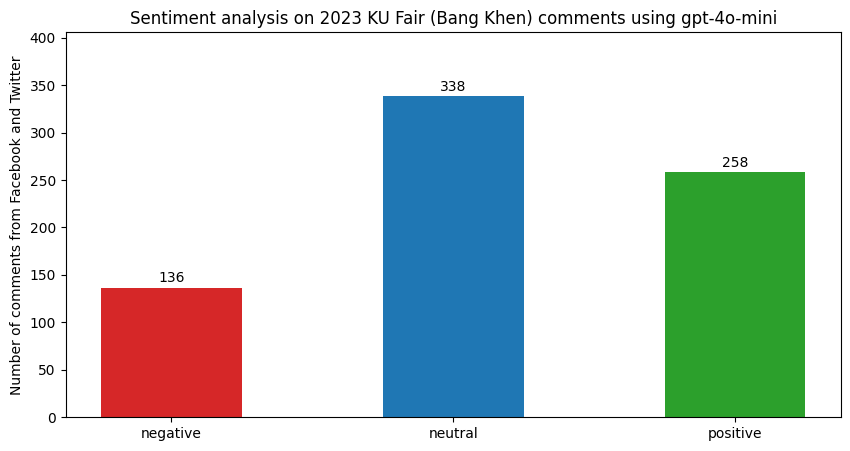

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))
x = df_w_gpt_answer.groupby('gpt-4o-mini_response').count().index.to_list()
y = df_w_gpt_answer.groupby('gpt-4o-mini_response').count().text.to_list()
bar_colors = ['tab:red', 'tab:blue', 'tab:green']
rects = ax.bar(x, y, width=0.5, color=bar_colors)
ax.bar_label(rects, padding=2)
ax.set_ylabel('Number of comments from Facebook and Twitter')
ax.set_title("Sentiment analysis on 2023 KU Fair (Bang Khen) comments using gpt-4o-mini")
ax.set_ylim(0, max(y)*1.2)
plt.show()

### Compare the result with manual_label

In [16]:
def sentiment_to_number(sentiment):
    '''
    convert sentiment to integer
    '''
    mapping_dict = {"negative":0, "neutral":1, "positive":2}
    return mapping_dict[sentiment.lower()]

prediction = df_w_gpt_answer['gpt-4o-mini_response'].apply(sentiment_to_number)
label = df['manual_Label'].apply(sentiment_to_number)

In [17]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

classes = ["negative", "neutral", "positive"]
print(classification_report(label, prediction, target_names=classes))

              precision    recall  f1-score   support

    negative       0.84      0.74      0.78       155
     neutral       0.78      0.73      0.75       360
    positive       0.69      0.82      0.75       217

    accuracy                           0.76       732
   macro avg       0.77      0.76      0.76       732
weighted avg       0.76      0.76      0.76       732



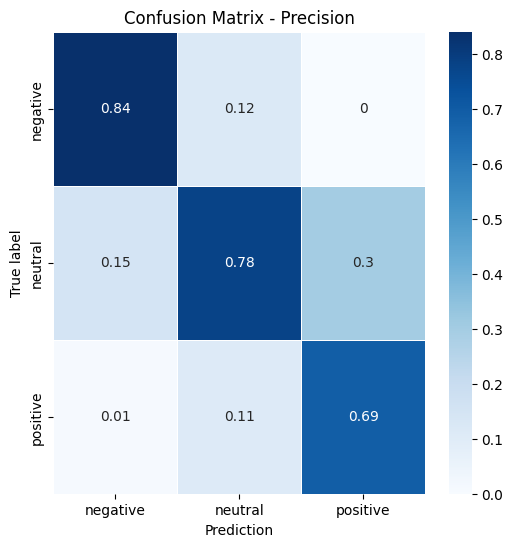

In [18]:
cm = confusion_matrix(label, prediction)
cm_sum = np.sum(cm, axis=0, keepdims=True)
cm_perc = np.round(cm / cm_sum.astype(np.float32), decimals=2)
cm_df = pd.DataFrame(cm_perc, index=classes, columns=classes )

fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(cm_df, linewidths=0.5, cmap=plt.cm.Blues, annot=True)
ax.set_xlabel("Prediction")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix - Precision")
plt.show()